In [1]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType
from functools import reduce
import pandas as pd
import glob

In [3]:
#Entrypoint 2.x
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CSV Merger").enableHiveSupport().getOrCreate()



# On yarn:
# spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().master("yarn").getOrCreate()
# specify .master("yarn")

sc = spark.sparkContext

In [4]:
def create_dict_from_csv(file_path):
    df = pd.read_csv(file_path)
    df['file_name'] = df['file_name'].str[:2]
    result_dict = pd.Series(df['file_name'].values, index=df['state']).to_dict()
    return result_dict

# Example usage
file_path = r'/home/talentum/myproject/dataSource/stations_info.csv'
state_dict = create_dict_from_csv(file_path)
print(state_dict)


{'Andhra Pradesh': 'AP', 'Arunachal Pradesh': 'AR', 'Assam': 'AS', 'Bihar': 'BR', 'Chhattisgarh': 'CG', 'Chandigarh': 'CH', 'Delhi': 'DL', 'Gujarat': 'GJ', 'Himachal Pradesh': 'HP', 'Haryana': 'HR', 'Jharkhand': 'JH', 'Jammu and Kashmir': 'JK', 'Karnataka': 'KA', 'Kerala': 'KL', 'Maharashtra': 'MH', 'Meghalaya': 'ML', 'Manipur': 'MN', 'Madhya Pradesh': 'MP', 'Mizoram': 'MZ', 'Nagaland': 'NL', 'Odisha': 'OR', 'Punjab': 'PB', 'Puducherry': 'PY', 'Rajasthan': 'RJ', 'Sikkim': 'SK', 'Telangana': 'TG', 'Tamil Nadu': 'TN', 'Tripura': 'TR', 'Uttarakhand': 'UK', 'Uttar Pradesh': 'UP', 'West Bengal': 'WB'}


In [5]:
print(list(state_dict.values()))


['AP', 'AR', 'AS', 'BR', 'CG', 'CH', 'DL', 'GJ', 'HP', 'HR', 'JH', 'JK', 'KA', 'KL', 'MH', 'ML', 'MN', 'MP', 'MZ', 'NL', 'OR', 'PB', 'PY', 'RJ', 'SK', 'TG', 'TN', 'TR', 'UK', 'UP', 'WB']


### merging cities with respect to states

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType
import os

# Initialize Spark session
spark = SparkSession.builder.appName("CSVProcessor").getOrCreate()

# Define the directory paths
directory_path = 'file:////home/talentum/myproject/dataSource/archive'
savepath = 'file:////home/talentum/myproject/dataSource/output'

# Define the prefixes you want to handle (assuming state_dict is defined elsewhere)
prefixes = list(state_dict.values())  # Add other prefixes as needed

# Function to normalize column names
def normalize_column_names(df):
    normalized_columns = [col.strip().replace(' ', '_').replace('.', '_').replace('(', '').replace(')', '') for col in df.columns]
    return df.toDF(*normalized_columns)

# Function to ensure correct data types
def ensure_data_types(df, columns):
    for column in columns:
        if column not in df.columns:
            df = df.withColumn(column, lit(None).cast(StringType()))
    return df.select(columns)

# Process each prefix
for prefix in prefixes:
    # Define the search pattern
    search_pattern = os.path.join(directory_path, f'{prefix}*.csv')
    
    # Read all CSV files using Spark's read method
    df = spark.read.option("header", "true").csv(search_pattern, inferSchema=True)
    
    if df.count() > 0:
        # Normalize column names
        df = normalize_column_names(df)
        
        # Identify all columns in the DataFrame
        all_columns = sorted(df.columns)  # Sort columns for consistency
        
        # Ensure DataFrame has the correct columns and data types
        df = ensure_data_types(df, all_columns)
        
        # Extract state abbreviation from file names (assuming prefix is the state abbreviation)
        state_abbr = prefix
        state_name = next((name for name, abbr in state_dict.items() if abbr == state_abbr), None)
        
        # Add the state column
        df = df.withColumn('state', lit(state_name).cast(StringType()))
        
        # Save the DataFrame to a single CSV file
        output_path = os.path.join(savepath, f'{prefix}')
        df.coalesce(1).write.option("header", "true").csv(output_path, mode='overwrite')
        print(f"Merged CSV files for prefix '{prefix}' saved as part csv file inside {prefix} folder'")
    else:
        print(f"No valid files found for prefix '{prefix}'.")

# Stop the Spark session
spark.stop()


### data cleaning(state wise)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when, mean as _mean, to_date, count, isnull
from pyspark.sql.types import DoubleType

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

def handle_outliers(df, column):
    """Handle outliers in a specific column using the IQR method."""
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df.withColumn(column, when((col(column) < lower_bound) | (col(column) > upper_bound), None).otherwise(col(column)))
    median_value = df.approxQuantile(column, [0.5], 0.01)[0]
    df = df.fillna({column: median_value})
    return df

def process_csv_file(file_path, output_dir, state_code):
    """Read, clean, and save a single CSV file."""
    # Read the CSV file into a DataFrame
    df = spark.read.option("header", "true").csv(file_path, inferSchema=True)
    
    total_columns = len(df.columns)
    missing_threshold_row = total_columns * 0.85
    df = df.withColumn('missing_count', sum([isnull(col(c)).cast('int') for c in df.columns]))
    df = df.filter(col('missing_count') <= missing_threshold_row).drop('missing_count')

    # Step 2: Drop columns with more than 50% missing values (based on the new row count)
    total_rows = df.count()
    missing_threshold_col = total_rows * 0.60
    missing_value_counts = {c: df.filter(isnull(col(c))).count() for c in df.columns}
    cols_to_drop = [c for c in missing_value_counts if missing_value_counts[c] > missing_threshold_col]
    df = df.drop(*cols_to_drop)
    
    # Handle outliers and impute missing values for numeric columns
    numeric_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, DoubleType)]
    for column in numeric_columns:
        df = handle_outliers(df, column)
    
    # Remove duplicates
    df = df.dropDuplicates()
    
    # Convert date columns
    if 'From Date' in df.columns and 'To Date' in df.columns:
        df = df.withColumn('From_Date', to_date(col('From Date'), 'yyyy-MM-dd'))
        df = df.withColumn('To_Date', to_date(col('To Date'), 'yyyy-MM-dd'))
        df = df.drop('From Date', 'To Date')
    
    # Normalize column names
    normalized_columns = [col.strip().replace(' ', '_').replace('.', '_').replace('(', '').replace(')', '').lower() for col in df.columns]
    df = df.toDF(*normalized_columns)
    
    # Show the DataFrame and print remaining columns
    df.show()
    print(f"Columns after cleaning: {df.columns}")
    
    # Print a red warning if the number of columns is less than 12
    if len(df.columns) < 12:
        print("\033[91mWarning: The number of columns after cleaning is less than 10.\033[0m")
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the cleaned DataFrame to a single CSV file
    output_file = os.path.join(output_dir, f'{state_code}')
    df.coalesce(1).write.option("header", "true").csv(f'file://{output_file}', mode='overwrite')
    print(f'Cleaned data saved to {output_file}')

def process_all_files(state_codes, base_path, output_dir):
    """Process CSV files from multiple state codes."""
    for state_code in state_codes:
        file_path = os.path.join(base_path, state_code, '*.csv')
        process_csv_file(file_path, output_dir, state_code)

# Define state codes, base path, and output directory
state_codes = list(state_dict.values())  # Example state codes
# state_codes = ['JH']
base_path = 'file:///home/talentum/myproject/dataSource/output'
output_dir = '/home/talentum/myproject/dataSource/output/Cleaned'

# Process all files
process_all_files(state_codes, base_path, output_dir)

# Stop the Spark session
spark.stop()
# base_cleaned_file_path='hdfs:///user/talentum/output'

In [ ]:
#JH has less params
#red color

### EDA

In [ ]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean as _mean, isnull
from pyspark.sql.types import DoubleType, IntegerType

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("CSVProcessing") \
    .getOrCreate()

def process_csv_files_from_path(path_pattern):
    """Process all CSV files matching a path pattern."""
    try:
        # Load all CSV files into a DataFrame using the path pattern
        df = spark.read.option("header", "true").csv(path_pattern, inferSchema=True)
        
        # Calculate the mean of each numeric column
        numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType))]
        mean_values = df.select([_mean(col(column)).alias(column) for column in numeric_columns]).collect()[0].asDict()
        
        # Calculate the number of null values per column
        null_counts = {column: df.filter(isnull(col(column))).count() for column in df.columns}
        
        # Total number of rows and columns
        total_rows = df.count()
        total_columns = len(df.columns)

        # Print the results
        print(f"Processing files matching: {path_pattern}")
        print(f"Total Rows: {total_rows}")
        print(f"Total Columns: {total_columns}")
        print("Mean of each feature column:")
        print(mean_values)
        print("Number of null values per column:")
        print(null_counts)
        print()  # Blank line for better readability
    except Exception as e:
        print(f"An error occurred while processing files with pattern {path_pattern}: {e}")

def process_files_for_state_code(state_code, base_paths):
    """Process all CSV files for a single state code across multiple base paths."""
    for base_path in base_paths: 
        print("******************************************************************************************")
        print(f"Processing base path: {base_path} for state code: {state_code}")
        directory = os.path.join(base_path, state_code)
        path_pattern = os.path.join(directory, '*.csv')  # Use wildcard to match all CSV files in the directory
        process_csv_files_from_path(path_pattern)

# Define base paths for directories
base_paths = [
    'file:///home/talentum/myproject/dataSource/output',
    'file:///home/talentum/myproject/dataSource/output/Cleaned'
]

# Example state codes
state_codes = list(state_dict.values())

# Process all files for each state code across all base paths
for state_code in state_codes:
    process_files_for_state_code(state_code, base_paths)

# Stop the Spark session
spark.stop()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, IntegerType
import os
import glob

# Initialize Spark session
spark = SparkSession.builder \
    .appName("OutlierDetection") \
    .getOrCreate()

def count_outliers_in_csv(file_path):
    """Count outliers in a given CSV file."""
    # Ensure the file path uses the correct prefix for local files
    if not file_path.startswith('file:///'):
        file_path = 'file://' + file_path

    # Read the CSV file into a DataFrame
    df = spark.read.option("header", "true").csv(file_path, inferSchema=True)

    # Function to identify and count outliers using the IQR method
    def count_outliers(df, column):
        # Calculate Q1 and Q3 using approxQuantile function
        quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
        q1, q3 = quantiles
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Count outliers
        outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
        outlier_count = outliers.count()

        return outlier_count

    # Dictionary to store the count of outliers for each column
    outlier_counts = {}

    # Apply the outlier counting function to numeric columns only
    for column in df.columns:
        dtype = df.schema[column].dataType
        if isinstance(dtype, (DoubleType, IntegerType)):
            outlier_count = count_outliers(df, column)
            outlier_counts[column] = outlier_count

    # Print the results
    for column, count in outlier_counts.items():
        if count > 0:
            print(f"Column '{column}' has {count} outlier(s).")
        else:
            print(f"Column '{column}' has no outliers.")

    return outlier_counts

def process_csv_files(base_path, state_codes):
    """Process all CSV files for the given state codes."""
    for state_code in state_codes:
        # Construct the directory path
        print("*"*20+f'{state_code}'+"*"*20)
        directory_path = os.path.join(base_path, state_code)
        print(f"Looking for files in directory: {directory_path}")  # Debugging line

        # Construct the search pattern for CSV files
        search_pattern = os.path.join(directory_path, '*.csv')
        print(f"Search pattern: {search_pattern}")  # Debugging line

        # List all CSV files in the directory
        csv_files = glob.glob(search_pattern)

        if not csv_files:
            print(f"No CSV files found in directory: {directory_path}")
            continue

        # Process each CSV file
        for file_path in csv_files:
            print(f"Processing file: {file_path}")
            try:
                outlier_counts = count_outliers_in_csv(file_path)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

# Example usage
state_codes = list(state_dict.values()) # Replace with actual state codes
base_path = '/home/talentum/myproject/dataSource/output'  # Local base path

process_csv_files(base_path, state_codes)

# Stop the Spark session
spark.stop()


### save file as parquet after merging states

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit

In [ ]:
# Initialize a Spark session
spark = SparkSession.builder.appName("CSV Merge").getOrCreate()

# List of state codes (assuming state_dict is defined elsewhere in your code)
state_codes = list(state_dict.values())

# Read the CSV files into a list of DataFrames
dfs = []
print("Starting to read CSV files...")
for state_code in state_codes:
    file_path = f"file:///home/talentum/myproject/dataSource/output/Cleaned/{state_code}/*.csv"
    print(f"Reading files from: {file_path}")
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    print(f"Read {df.count()} rows for state code: {state_code}")
    dfs.append(df)

print("Finished reading CSV files.")
print("Starting to clean column names...")

# Function to clean column names by replacing special characters with underscores
def clean_column_names(df):
    for col_name in df.columns:
        new_col_name = col_name.replace('-', '_').replace('/', '_').replace(' ', '_')
        df = df.withColumnRenamed(col_name, new_col_name)
    return df

# Clean column names for each DataFrame
dfs = [clean_column_names(df) for df in dfs]

print("Finished cleaning column names.")
print("Starting to ensure all DataFrames have the same columns...")

# Get the list of all columns
all_columns = set()
for df in dfs:
    all_columns.update(df.columns)

# Ensure all DataFrames have all columns
def add_missing_columns(df, all_columns):
    for column in all_columns:
        if column not in df.columns:
            df = df.withColumn(column, lit(None).cast("string"))
    return df

dfs = [add_missing_columns(df, all_columns) for df in dfs]

print("Finished ensuring all DataFrames have the same columns.")
print("Starting to select columns in the same order for consistency...")

# Select the columns in the same order for consistency
dfs = [df.select(*all_columns) for df in dfs]

print("Finished selecting columns in the same order.")
print("Starting to merge DataFrames...")

# Merge the DataFrames
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = merged_df.unionByName(df)

print("Finished merging DataFrames.")
print("Starting to save the merged DataFrame to a Parquet file...")

# Coalesce to a single partition and save the merged DataFrame to a Parquet file
merged_df.coalesce(1).write.parquet("file:///home/talentum/myproject/dataSource/output/merged_final")

print("Finished saving the merged DataFrame as Parquet.")
print("Stopping the Spark session...")

# Stop the Spark session
spark.stop()

print("Spark session stopped.")


### save as csv file according to coalesce

In [ ]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import col, lit

# # Initialize a Spark session
# spark = SparkSession.builder.appName("CSV Merge").getOrCreate()

# # List of state codes (assuming state_dict is defined elsewhere in your code)
# state_codes = list(state_dict.values())

# # Read the CSV files into a list of DataFrames
# dfs = []
# print("Starting to read CSV files...")
# for state_code in state_codes:
#     file_path = f"file:///home/talentum/myproject/dataSource/output/Cleaned/{state_code}/*.csv"
#     print(f"Reading files from: {file_path}")
#     df = spark.read.csv(file_path, header=True, inferSchema=True)
#     print(f"Read {df.count()} rows for state code: {state_code}")
#     dfs.append(df)

# print("Finished reading CSV files.")
# print("Starting to clean column names...")

# # Function to clean column names by replacing special characters with underscores
# def clean_column_names(df):
#     for col_name in df.columns:
#         new_col_name = col_name.replace('-', '_').replace('/', '_').replace(' ', '_')
#         df = df.withColumnRenamed(col_name, new_col_name)
#     return df

# # Clean column names for each DataFrame
# dfs = [clean_column_names(df) for df in dfs]

# print("Finished cleaning column names.")
# print("Starting to ensure all DataFrames have the same columns...")

# # Get the list of all columns
# all_columns = set()
# for df in dfs:
#     all_columns.update(df.columns)

# # Ensure all DataFrames have all columns
# def add_missing_columns(df, all_columns):
#     for column in all_columns:
#         if column not in df.columns:
#             df = df.withColumn(column, lit(None).cast("string"))
#     return df

# dfs = [add_missing_columns(df, all_columns) for df in dfs]

# print("Finished ensuring all DataFrames have the same columns.")
# print("Starting to select columns in the same order for consistency...")

# # Select the columns in the same order for consistency
# dfs = [df.select(*all_columns) for df in dfs]

# print("Finished selecting columns in the same order.")
# print("Starting to merge DataFrames...")

# # Merge the DataFrames
# merged_df = dfs[0]
# for df in dfs[1:]:
#     merged_df = merged_df.unionByName(df)

# print("Finished merging DataFrames.")
# print("Starting to save the merged DataFrame to a CSV file...")

# # Coalesce to a single partition and save the merged DataFrame to a CSV file
# merged_df.coalesce(20).write.csv("file:///home/talentum/myproject/dataSource/output/merged_final_csv", header=True)

# print("Finished saving the merged DataFrame as CSV.")
# print("Stopping the Spark session...")

# # Stop the Spark session
# spark.stop()

# print("Spark session stopped.")


# Final cleaning

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, to_date, col
from pyspark.sql.types import StringType
from math import ceil
from pyspark import StorageLevel
import pandas as pd

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Read Parquet File") \
    .getOrCreate()


# Define the path to the Parquet file
parquet_file_path = "file:///home/talentum/myproject/dataSource/output/merged_final/*.parquet"

# Read the Parquet file into a DataFrame
df = spark.read.parquet(parquet_file_path)

df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])
df.select("from_date").show(5)
# Shape of the dataset
print('Shape of the dataset: ', (df.count(), len(df.columns)))

from_date_null_count = df.filter(col("from_date").isNull()).count()
to_date_null_count = df.filter(col("to_date").isNull()).count()

print(f"Null values in 'from_date': {from_date_null_count}")
print(f"Null values in 'to_date': {to_date_null_count}")
# Stop the Spark session
# df = df.persist(StorageLevel.MEMORY_AND_DISK)
print("Let's print first 5 data rows:")
df.limit(5).toPandas()


root
 |-- bp_mmhg: string (nullable = true)
 |-- benzene_ug_m3: string (nullable = true)
 |-- mp_xylene_ug_m3: string (nullable = true)
 |-- o_xylene_ug_m3: string (nullable = true)
 |-- xylene_ug_m3: string (nullable = true)
 |-- co_mg_m3: string (nullable = true)
 |-- nh3_ug_m3: string (nullable = true)
 |-- so2_ug_m3: double (nullable = true)
 |-- at_degree: string (nullable = true)
 |-- rf_mm: string (nullable = true)
 |-- temp_degree_c: string (nullable = true)
 |-- from_date: string (nullable = true)
 |-- eth_benzene_ug_m3: string (nullable = true)
 |-- state: string (nullable = true)
 |-- temp_: string (nullable = true)
 |-- at_degree_c: string (nullable = true)
 |-- wd_degree: string (nullable = true)
 |-- wd_deg: string (nullable = true)
 |-- nox_ppb: string (nullable = true)
 |-- no_ug_m3: double (nullable = true)
 |-- toluene_ug_m3: string (nullable = true)
 |-- rh_degree: string (nullable = true)
 |-- nox_ug_m3: string (nullable = true)
 |-- to_date: string (nullable = true

,bp_mmhg,benzene_ug_m3,mp_xylene_ug_m3,o_xylene_ug_m3,xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,at_degree,rf_mm,...,nox_ug_m3,to_date,ozone_ug_m3,pm10_ug_m3,sr_w_mt2,vws_m_s,ws_m_s,no2_ug_m3,pm2_5_ug_m3,rh_%
0,218.5,0.4,None,None,0.1,0.26,6.88,3.28,None,0.0,...,None,06-07-2016 23:00,13.78,12.5,10.0,-0.1,2.07,25.78,3.75,78.75
1,218.5,1.13,None,None,0.5,0.46,10.02,5.33,None,0.0,...,None,16-07-2016 13:00,15.5,47.0,3.0,0.2,1.03,32.47,12.33,59.33
2,218.5,0.7,None,None,0.1,0.55,8.47,6.20,None,0.0,...,None,29-07-2016 18:00,11.87,24.33,3.0,0.27,1.23,51.73,4.0,74.33
3,218.5,0.85,None,None,0.1,0.57,7.7,5.00,None,0.0,...,None,12-08-2016 16:00,9.15,89.25,3.0,1.0,1.12,61.20,18.75,59.5
4,218.5,1.0,None,None,0.1,0.27,6.73,7.25,None,0.0,...,None,14-08-2016 00:00,17.85,75.5,6.0,0.23,1.33,55.72,29.25,65.25


In [12]:
# Get a list of all column names and their data types
column_info = df.dtypes

# Filter the list to only include numerical columns
numerical_columns = [col[0] for col in column_info if col[1] in ("IntegerType", "double")]
string_columns = [col[0] for col in column_info if col[1] == "string"]

print("All Numerial columns:")
print(numerical_columns)
print("\n")
print("All string columns:")
print(string_columns)

All Numerial columns:
['so2_ug_m3', 'no_ug_m3', 'no2_ug_m3']


All string columns:
['bp_mmhg', 'benzene_ug_m3', 'mp_xylene_ug_m3', 'o_xylene_ug_m3', 'xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'at_degree', 'rf_mm', 'temp_degree_c', 'eth_benzene_ug_m3', 'state', 'temp_', 'at_degree_c', 'wd_degree', 'wd_deg', 'nox_ppb', 'toluene_ug_m3', 'rh_degree', 'nox_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'sr_w_mt2', 'vws_m_s', 'ws_m_s', 'pm2_5_ug_m3', 'rh_%']


In [13]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import rand, to_date, col

In [14]:
# assume 'df' is your PySpark DataFrame and 'source' is your column name
df = df.withColumn("from_date", to_date(col("from_date"), "yyyy-MM-dd"))\
        .withColumn("to_date", to_date(col("to_date"), "yyyy-MM-dd"))

In [15]:


print(len(df.columns))
from_date_null_count = df.filter(col("from_date").isNull()).count()
to_date_null_count = df.filter(col("to_date").isNull()).count()

print(f"Null values in 'from_date': {from_date_null_count}")
print(f"Null values in 'to_date': {to_date_null_count}")

32
Null values in 'from_date': 102938
Null values in 'to_date': 102938


In [16]:
# Drop rows where 'from_date' or 'to_date' is null
df = df.dropna(subset=["from_date", "to_date"])

from_date_null_count = df.filter(col("from_date").isNull()).count()
to_date_null_count = df.filter(col("to_date").isNull()).count()

print(f"Null values in 'from_date': {from_date_null_count}")
print(f"Null values in 'to_date': {to_date_null_count}")

Null values in 'from_date': 0
Null values in 'to_date': 0


In [17]:
columns_to_cast = [c for c in df.columns if c not in ['state','from_date','to_date']]
for c in columns_to_cast:
    df = df.withColumn(c, col(c).cast("double"))   

In [18]:
numerical_columns_new = [col[0] for col in df.dtypes if col[1] in ("IntegerType", "double")]
string_columns_new = [col[0] for col in df.dtypes if col[1] == "string"]

print("All Numerial columns:")
print(numerical_columns_new)
print("\n")
print("All string columns:")
print(string_columns_new)

All Numerial columns:
['bp_mmhg', 'benzene_ug_m3', 'mp_xylene_ug_m3', 'o_xylene_ug_m3', 'xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'at_degree', 'rf_mm', 'temp_degree_c', 'eth_benzene_ug_m3', 'temp_', 'at_degree_c', 'wd_degree', 'wd_deg', 'nox_ppb', 'no_ug_m3', 'toluene_ug_m3', 'rh_degree', 'nox_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'sr_w_mt2', 'vws_m_s', 'ws_m_s', 'no2_ug_m3', 'pm2_5_ug_m3', 'rh_%']


All string columns:
['state']


In [19]:
df.printSchema()

root
 |-- bp_mmhg: double (nullable = true)
 |-- benzene_ug_m3: double (nullable = true)
 |-- mp_xylene_ug_m3: double (nullable = true)
 |-- o_xylene_ug_m3: double (nullable = true)
 |-- xylene_ug_m3: double (nullable = true)
 |-- co_mg_m3: double (nullable = true)
 |-- nh3_ug_m3: double (nullable = true)
 |-- so2_ug_m3: double (nullable = true)
 |-- at_degree: double (nullable = true)
 |-- rf_mm: double (nullable = true)
 |-- temp_degree_c: double (nullable = true)
 |-- from_date: date (nullable = true)
 |-- eth_benzene_ug_m3: double (nullable = true)
 |-- state: string (nullable = true)
 |-- temp_: double (nullable = true)
 |-- at_degree_c: double (nullable = true)
 |-- wd_degree: double (nullable = true)
 |-- wd_deg: double (nullable = true)
 |-- nox_ppb: double (nullable = true)
 |-- no_ug_m3: double (nullable = true)
 |-- toluene_ug_m3: double (nullable = true)
 |-- rh_degree: double (nullable = true)
 |-- nox_ug_m3: double (nullable = true)
 |-- to_date: date (nullable = true)
 |

In [20]:
df.select("from_date").show(5)

+----------+
| from_date|
+----------+
|2017-07-03|
|2017-07-07|
|2017-07-08|
|2017-07-15|
|2017-07-17|
+----------+
only showing top 5 rows



In [21]:
df.select("state").distinct().show()

+-----------------+
|            state|
+-----------------+
|         Nagaland|
|        Karnataka|
|           Odisha|
|           Kerala|
|       Tamil Nadu|
|     Chhattisgarh|
|   Andhra Pradesh|
|   Madhya Pradesh|
|           Punjab|
|          Manipur|
|          Mizoram|
| Himachal Pradesh|
|       Puducherry|
|          Haryana|
|Jammu and Kashmir|
|        Jharkhand|
|Arunachal Pradesh|
|          Gujarat|
|           Sikkim|
|            Delhi|
+-----------------+
only showing top 20 rows



In [22]:
distinct_state_count = df.select("state").distinct().count()
print(f"Number of distinct states: {distinct_state_count}")

Number of distinct states: 31


In [23]:
df.groupBy("state").count().orderBy("state").show(31,truncate=False)

+-----------------+-------+
|state            |count  |
+-----------------+-------+
|Andhra Pradesh   |122778 |
|Arunachal Pradesh|8131   |
|Assam            |73172  |
|Bihar            |636501 |
|Chandigarh       |54786  |
|Chhattisgarh     |49048  |
|Delhi            |2118037|
|Gujarat          |346017 |
|Haryana          |1110835|
|Himachal Pradesh |8851   |
|Jammu and Kashmir|16792  |
|Jharkhand        |52624  |
|Karnataka        |1087206|
|Kerala           |264335 |
|Madhya Pradesh   |572106 |
|Maharashtra      |1264555|
|Manipur          |14918  |
|Meghalaya        |30422  |
|Mizoram          |24991  |
|Nagaland         |21414  |
|Odisha           |102796 |
|Puducherry       |19109  |
|Punjab           |374848 |
|Rajasthan        |485589 |
|Sikkim           |8048   |
|Tamil Nadu       |518525 |
|Telangana        |390250 |
|Tripura          |29013  |
|Uttar Pradesh    |1641091|
|Uttarakhand      |10560  |
|West Bengal      |559152 |
+-----------------+-------+



In [24]:
df1=df

In [25]:
for col_name in df1.columns:
    if col_name not in ["to_date", "from_date"]:
        null_count = df1.filter(col(col_name).isNull()).count()
        print(f"'{col_name}':'{null_count}'")


'bp_mmhg':'2268611'
'benzene_ug_m3':'393359'
'mp_xylene_ug_m3':'5255939'
'o_xylene_ug_m3':'5598049'
'xylene_ug_m3':'8980485'
'co_mg_m3':'52624'
'nh3_ug_m3':'3807766'
'so2_ug_m3':'0'
'at_degree':'12005940'
'rf_mm':'10184848'
'temp_degree_c':'3618911'
'eth_benzene_ug_m3':'8095438'
'state':'0'
'temp_':'10820847'
'at_degree_c':'7084985'
'wd_degree':'10985297'
'wd_deg':'1083827'
'nox_ppb':'155420'
'no_ug_m3':'0'
'toluene_ug_m3':'556254'
'rh_degree':'11913704'
'nox_ug_m3':'11913704'
'ozone_ug_m3':'49048'
'pm10_ug_m3':'2137586'
'sr_w_mt2':'1861137'
'vws_m_s':'6820905'
'ws_m_s':'52624'
'no2_ug_m3':'0'
'pm2_5_ug_m3':'52624'
'rh_%':'155420'


In [26]:
from pyspark.sql.functions import col, sum

# List of columns to ignore
ignore_columns = ["to_date", "from_date"]

# Filter out the ignored columns
filtered_columns = [c for c in df1.columns if c not in ignore_columns]

total_count = df1.count()

# Calculate null counts for the filtered columns
null_counts = df1.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in filtered_columns])

# Calculate null percentage for the filtered columns
null_counts_percent = null_counts.select([(col(c) / total_count) * 100 for c in null_counts.columns])

# Convert to Pandas DataFrame and transpose
null_counts_percent_pd = null_counts_percent.toPandas().transpose()

# Rename the column and format the percentages
null_counts_percent_pd.columns = ['Null Percentage']
null_counts_percent_pd['Null Percentage'] = null_counts_percent_pd['Null Percentage'].apply(lambda x: '{:.2f}%'.format(x))

null_counts_percent_pd


,Null Percentage
((bp_mmhg / 12016500) * 100),18.88%
((benzene_ug_m3 / 12016500) * 100),3.27%
((mp_xylene_ug_m3 / 12016500) * 100),43.74%
((o_xylene_ug_m3 / 12016500) * 100),46.59%
((xylene_ug_m3 / 12016500) * 100),74.73%
((co_mg_m3 / 12016500) * 100),0.44%
((nh3_ug_m3 / 12016500) * 100),31.69%
((so2_ug_m3 / 12016500) * 100),0.00%
((at_degree / 12016500) * 100),99.91%
((rf_mm / 12016500) * 100),84.76%


In [27]:
from pyspark.sql.functions import col
import re



# Columns to ignore
ignore_columns = ["to_date", "from_date", "state"]

# Check if 'Null Percentage' contains strings and remove '%' symbol if necessary
if null_counts_percent_pd['Null Percentage'].dtype == 'object':
    null_counts_percent_pd['Null Percentage'] = null_counts_percent_pd['Null Percentage'].str.rstrip('%').astype(float)

# Filter the DataFrame to exclude the ignored columns
filtered_null_counts_percent_pd = null_counts_percent_pd.drop(ignore_columns, errors='ignore')

# Filter the columns with 'Null Percentage' more than 50%
high_null_columns = filtered_null_counts_percent_pd[filtered_null_counts_percent_pd['Null Percentage'] > 50]

# Print the column names
for column in high_null_columns.index:
    print(column)



# Drop the columns
#columns_to_drop1 = [re.search(r'([^\/]+)', col).group(1).strip().replace('(', '').replace(')', '') for col in columns_to_drop]
columns_to_drop1 = ['xylene_ug_m3', 'at_degree', 'rf_mm', 'eth_benzene_ug_m3', 'temp_', 'at_degree_c', 'wd_degree', 'rh_degree', 'nox_ug_m3', 'vws_m_s']
df1_dropped = df1.drop(*columns_to_drop1)

print("Columns dropped:", columns_to_drop1)
print("\n")
print("New DataFrame shape:", df1_dropped.count(), "x", len(df1_dropped.columns))


((xylene_ug_m3 / 12016500) * 100)
((at_degree / 12016500) * 100)
((rf_mm / 12016500) * 100)
((eth_benzene_ug_m3 / 12016500) * 100)
((temp_ / 12016500) * 100)
((at_degree_c / 12016500) * 100)
((wd_degree / 12016500) * 100)
((rh_degree / 12016500) * 100)
((nox_ug_m3 / 12016500) * 100)
((vws_m_s / 12016500) * 100)
Columns dropped: ['xylene_ug_m3', 'at_degree', 'rf_mm', 'eth_benzene_ug_m3', 'temp_', 'at_degree_c', 'wd_degree', 'rh_degree', 'nox_ug_m3', 'vws_m_s']


New DataFrame shape: 12016500 x 22


In [28]:
print("number of columns dropped = {}".format(len(columns_to_drop1)))
print("original number of columns available = {}".format(len(df1.columns)))

number of columns dropped = 10
original number of columns available = 32


In [29]:
df1_dropped.printSchema()

root
 |-- bp_mmhg: double (nullable = true)
 |-- benzene_ug_m3: double (nullable = true)
 |-- mp_xylene_ug_m3: double (nullable = true)
 |-- o_xylene_ug_m3: double (nullable = true)
 |-- co_mg_m3: double (nullable = true)
 |-- nh3_ug_m3: double (nullable = true)
 |-- so2_ug_m3: double (nullable = true)
 |-- temp_degree_c: double (nullable = true)
 |-- from_date: date (nullable = true)
 |-- state: string (nullable = true)
 |-- wd_deg: double (nullable = true)
 |-- nox_ppb: double (nullable = true)
 |-- no_ug_m3: double (nullable = true)
 |-- toluene_ug_m3: double (nullable = true)
 |-- to_date: date (nullable = true)
 |-- ozone_ug_m3: double (nullable = true)
 |-- pm10_ug_m3: double (nullable = true)
 |-- sr_w_mt2: double (nullable = true)
 |-- ws_m_s: double (nullable = true)
 |-- no2_ug_m3: double (nullable = true)
 |-- pm2_5_ug_m3: double (nullable = true)
 |-- rh_%: double (nullable = true)



In [30]:
print("dropped columns ")
null_counts_percent_pd[null_counts_percent_pd['Null Percentage'] > 50.00]

dropped columns 


,Null Percentage
((xylene_ug_m3 / 12016500) * 100),74.73
((at_degree / 12016500) * 100),99.91
((rf_mm / 12016500) * 100),84.76
((eth_benzene_ug_m3 / 12016500) * 100),67.37
((temp_ / 12016500) * 100),90.05
((at_degree_c / 12016500) * 100),58.96
((wd_degree / 12016500) * 100),91.42
((rh_degree / 12016500) * 100),99.14
((nox_ug_m3 / 12016500) * 100),99.14
((vws_m_s / 12016500) * 100),56.76


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # assume 'df' is your PySpark DataFrame

# # convert the DataFrame to a Pandas DataFrame
# pdf = df1_dropped.limit(800000).toPandas()

# # iterate over each column and create a density plot, ignoring string columns
# for col in pdf.columns:
#     if pd.api.types.is_numeric_dtype(pdf[col]):
#         plt.figure(figsize=(8, 6))
#         sns.kdeplot(pdf[col], shade=True)
#         plt.title(f"Density Plot of {col}")
#         plt.xlabel(col)
#         plt.ylabel("Density")
#         plt.show()


In [31]:
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from pyspark.ml.feature import Imputer

numeric_column_names = [column.name for column in df1_dropped.schema.fields
                        if isinstance(column.dataType, (IntegerType, FloatType, DoubleType))]



# Initialize the Imputer
imputer = Imputer(
    inputCols= numeric_column_names, #specifying the input column names
    outputCols=numeric_column_names, #specifying the output column names
    strategy="median"                  # or "median" if you want to use the median value
)

# Fit the Imputer
model = imputer.fit(df1_dropped)

#Transform the dataset
imputed_df = model.transform(df1_dropped)

In [32]:
numeric_column_names

['bp_mmhg',
 'benzene_ug_m3',
 'mp_xylene_ug_m3',
 'o_xylene_ug_m3',
 'co_mg_m3',
 'nh3_ug_m3',
 'so2_ug_m3',
 'temp_degree_c',
 'wd_deg',
 'nox_ppb',
 'no_ug_m3',
 'toluene_ug_m3',
 'ozone_ug_m3',
 'pm10_ug_m3',
 'sr_w_mt2',
 'ws_m_s',
 'no2_ug_m3',
 'pm2_5_ug_m3',
 'rh_%']

In [33]:
# Check whether null values are still present or not
from pyspark.sql.functions import col, sum

total_count = imputed_df.count()
null_counts = imputed_df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in imputed_df.columns])

null_counts_percent = null_counts.select([(col(c) / total_count) * 100 for c in null_counts.columns])

null_counts_percent_pd = null_counts_percent.toPandas().transpose()

null_counts_percent_pd.columns = ['Null Percentage']
null_counts_percent_pd['Null Percentage'] = null_counts_percent_pd['Null Percentage'].apply(lambda x: '{:.2f}%'.format(x))

null_counts_percent_pd

,Null Percentage
((bp_mmhg / 12016500) * 100),0.00%
((benzene_ug_m3 / 12016500) * 100),0.00%
((mp_xylene_ug_m3 / 12016500) * 100),0.00%
((o_xylene_ug_m3 / 12016500) * 100),0.00%
((co_mg_m3 / 12016500) * 100),0.00%
((nh3_ug_m3 / 12016500) * 100),0.00%
((so2_ug_m3 / 12016500) * 100),0.00%
((temp_degree_c / 12016500) * 100),0.00%
((from_date / 12016500) * 100),0.00%
((state / 12016500) * 100),0.00%


In [34]:
imputed_df.select("from_date").show(5)

+----------+
| from_date|
+----------+
|2017-07-03|
|2017-07-07|
|2017-07-08|
|2017-07-15|
|2017-07-17|
+----------+
only showing top 5 rows



In [37]:
imputed_df.coalesce(1).write.parquet("file:///home/talentum/myproject/dataSource/output/final_parquet")

In [ ]:
spark.stop()

### final check for cleaned dataset

In [41]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Read Parquet and Show Columns") \
    .getOrCreate()

# Path to the Parquet file
parquet_file_path = "file:///home/talentum/myproject/dataSource/output/final_parquet/*.parquet"

# Read the Parquet file
df = spark.read.parquet(parquet_file_path)

# Get the list of column names
columns = df.columns

# Limit to the first 10 columns (if there are that many)
limited_columns = columns[2:12]

# Select only the limited columns from the DataFrame
df_limited = df.select(*limited_columns)

# Show the DataFrame
df_limited.show(50)
spark.stop()


+---------------+--------------+--------+---------+---------+-------------+----------+--------------+------+-------+
|mp_xylene_ug_m3|o_xylene_ug_m3|co_mg_m3|nh3_ug_m3|so2_ug_m3|temp_degree_c| from_date|         state|wd_deg|nox_ppb|
+---------------+--------------+--------+---------+---------+-------------+----------+--------------+------+-------+
|           2.19|          2.65|    0.87|      3.8|     20.2|         27.0|2017-07-03|Andhra Pradesh|297.75|  12.13|
|           2.19|          2.65|     0.0|     3.65|     20.2|        27.45|2017-07-07|Andhra Pradesh|288.75|  13.12|
|           2.19|          2.65|     0.0|      3.2|     6.85|         27.0|2017-07-08|Andhra Pradesh| 288.5|   8.72|
|           2.19|          2.65|     0.0|     3.48|     2.62|        29.63|2017-07-15|Andhra Pradesh| 295.5|    6.0|
|           2.19|          2.65|     0.0|     2.38|     7.75|        44.43|2017-07-17|Andhra Pradesh| 299.5|   8.63|
|           2.19|          2.65|    0.01|     4.13|    18.03|   

# HIVE

### first read schema from file for hive

In [42]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Read Parquet and Extract Schema") \
    .getOrCreate()

# Path to your Parquet file
parquet_file_path = "file:///home/talentum/myproject/dataSource/output/final_parquet/*.parquet"

# Read the Parquet file into a DataFrame
df = spark.read.parquet(parquet_file_path)

# Extract and print the schema
schema = df.schema
print("Schema of the Parquet file:")
print(schema)

# Stop the SparkSession
spark.stop()


Schema of the Parquet file:
StructType(List(StructField(bp_mmhg,DoubleType,true),StructField(benzene_ug_m3,DoubleType,true),StructField(mp_xylene_ug_m3,DoubleType,true),StructField(o_xylene_ug_m3,DoubleType,true),StructField(co_mg_m3,DoubleType,true),StructField(nh3_ug_m3,DoubleType,true),StructField(so2_ug_m3,DoubleType,true),StructField(temp_degree_c,DoubleType,true),StructField(from_date,DateType,true),StructField(state,StringType,true),StructField(wd_deg,DoubleType,true),StructField(nox_ppb,DoubleType,true),StructField(no_ug_m3,DoubleType,true),StructField(toluene_ug_m3,DoubleType,true),StructField(to_date,DateType,true),StructField(ozone_ug_m3,DoubleType,true),StructField(pm10_ug_m3,DoubleType,true),StructField(sr_w_mt2,DoubleType,true),StructField(ws_m_s,DoubleType,true),StructField(no2_ug_m3,DoubleType,true),StructField(pm2_5_ug_m3,DoubleType,true),StructField(rh_%,DoubleType,true)))


### create table in hive

In [ ]:
# CREATE TABLE AQI (
#     bp_mmhg DOUBLE,
#     benzene_ug_m3 DOUBLE,
#     mp_xylene_ug_m3 DOUBLE,
#     o_xylene_ug_m3 DOUBLE,
#     co_mg_m3 DOUBLE,
#     nh3_ug_m3 DOUBLE,
#     so2_ug_m3 DOUBLE,
#     temp_degree_c DOUBLE,
#     from_date TIMESTAMP,
#     state STRING,
#     wd_deg DOUBLE,
#     nox_ppb DOUBLE,
#     no_ug_m3 DOUBLE,
#     toluene_ug_m3 DOUBLE,
#     to_date TIMESTAMP,
#     ozone_ug_m3 DOUBLE,
#     pm10_ug_m3 DOUBLE,
#     sr_w_mt2 DOUBLE,
#     ws_m_s DOUBLE,
#     no2_ug_m3 DOUBLE,
#     pm2_5_ug_m3 DOUBLE,
#     rh_ DOUBLE
# )
# STORED AS PARQUET;


In [43]:
from pyspark.sql import SparkSession

# Initialize Spark Session with Hive support
spark = SparkSession.builder \
    .appName("Spark Hive Integration") \
    .config("spark.sql.catalogImplementation", "hive") \
    .enableHiveSupport() \
    .getOrCreate()

# Describe the Hive table
spark.sql("DESCRIBE project.aqi").show()

# Read a Parquet file into a DataFrame
parquet_file_path = "file:///home/talentum/myproject/dataSource/output/final_parquet"
df = spark.read.parquet(parquet_file_path)

# Write Data to the Hive table
df.write.mode("overwrite").saveAsTable("project.aqi")

# Read the data from the Hive table
df_from_hive = spark.sql("SELECT * FROM project.aqi")

# Show the top 50 rows
df_from_hive.show(50)

# Stop the Spark session
spark.stop()


+---------------+---------+-------+
|       col_name|data_type|comment|
+---------------+---------+-------+
|        bp_mmhg|   double|   null|
|  benzene_ug_m3|   double|   null|
|mp_xylene_ug_m3|   double|   null|
| o_xylene_ug_m3|   double|   null|
|       co_mg_m3|   double|   null|
|      nh3_ug_m3|   double|   null|
|      so2_ug_m3|   double|   null|
|  temp_degree_c|   double|   null|
|      from_date|timestamp|   null|
|          state|   string|   null|
|         wd_deg|   double|   null|
|        nox_ppb|   double|   null|
|       no_ug_m3|   double|   null|
|  toluene_ug_m3|   double|   null|
|        to_date|timestamp|   null|
|    ozone_ug_m3|   double|   null|
|     pm10_ug_m3|   double|   null|
|       sr_w_mt2|   double|   null|
|         ws_m_s|   double|   null|
|      no2_ug_m3|   double|   null|
+---------------+---------+-------+
only showing top 20 rows

+-------+-------------+---------------+--------------+--------+---------+---------+-------------+----------+--

### Exporting data for tableau

In [45]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("HiveToCSV") \
    .enableHiveSupport() \
    .getOrCreate()

# Define the Hive table name
hive_table = "project.aqi"

# Read data from Hive table
df = spark.sql(f"SELECT * FROM {hive_table}")

df = df.coalesce(1)

# Define the output CSV file path
output_file_path = "file:///home/talentum/myproject/dataSource/output/tableau"

# Save the Spark DataFrame as a CSV file
df.write.csv(output_file_path, header=True, mode="overwrite")

print(f"Data saved to {output_file_path}")

# Stop the Spark session
spark.stop()


Data saved to file:///home/talentum/myproject/dataSource/output/tableau


# ML part

### Sample size 

In [59]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, to_date, col
from pyspark.sql.types import StringType
from math import ceil
from pyspark import StorageLevel
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

# Initialize Spark session
spark = SparkSession.builder \
    .appName("LargeDatasetProcessing") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.cores", "3") \
    .config("spark.executor.instances", "2") \
    .getOrCreate()

# Set Spark configurations
spark.conf.set("spark.sql.shuffle.partitions", "300")  # Increase if shuffle operations are involved
spark.conf.set("spark.executor.extraJavaOptions", "-XX:+UseG1GC")  # Use G1 garbage collector
spark.conf.set("spark.memory.fraction", "0.6")  # Memory fraction for caching and execution
spark.conf.set("spark.network.timeout", "800s")
spark.conf.set("spark.rpc.askTimeout", "600s")
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "10000")
spark.conf.set("spark.sql.shuffle.partitions", "400")  # Increase based on the number of available cores
spark.conf.set("spark.shuffle.file.buffer", "128k")  # Buffer size for shuffle files

# Load data from a Parquet file (replace 'your_parquet_file_path' with the actual file path)
df = spark.read.parquet("file:///home/talentum/myproject/dataSource/output/final_parquet/*.parquet")

# Show schema to verify the format of 'from_date' and 'to_date'
df.printSchema()


# Step 1: Randomize the data
randomized_df = df.orderBy(rand())

# Step 2: Calculate suitable sample size
population_size = df.count()  # Total rows in the dataset
confidence_level = 1.96  # Z-score for 95% confidence
margin_of_error = 0.01  # 1% margin of error
std_dev = 0.5  # Standard deviation (assumed for binary outcome, can be adjusted)

# Sample size formula: n = (Z^2 * p * (1-p)) / e^2
sample_size = (confidence_level**2 * std_dev * (1 - std_dev)) / margin_of_error**2

# Adjust sample size for finite population correction
finite_sample_size = ceil(sample_size / (1 + (sample_size - 1) / population_size))

# Step 3: Extract the sample from the randomized data
sampled_df = randomized_df.limit(finite_sample_size)

# Select the first 10 columns
selected_columns = sampled_df.columns[:10]
pdf = sampled_df.select(*selected_columns)

# To cache
# pdf = pdf.persist(StorageLevel.MEMORY_AND_DISK)

num_rows = pdf.count()
num_columns = len(pdf.columns)

# Show dimensions
print(f"DataFrame Dimensions: {num_rows} rows, {num_columns} columns")

# Show the first 5 rows of the sample with only 10 columns
pdf.show(5)

# Unpersist and stop Spark session
# pdf.unpersist()
spark.stop()


root
 |-- bp_mmhg: double (nullable = true)
 |-- benzene_ug_m3: double (nullable = true)
 |-- mp_xylene_ug_m3: double (nullable = true)
 |-- o_xylene_ug_m3: double (nullable = true)
 |-- co_mg_m3: double (nullable = true)
 |-- nh3_ug_m3: double (nullable = true)
 |-- so2_ug_m3: double (nullable = true)
 |-- temp_degree_c: double (nullable = true)
 |-- from_date: date (nullable = true)
 |-- state: string (nullable = true)
 |-- wd_deg: double (nullable = true)
 |-- nox_ppb: double (nullable = true)
 |-- no_ug_m3: double (nullable = true)
 |-- toluene_ug_m3: double (nullable = true)
 |-- to_date: date (nullable = true)
 |-- ozone_ug_m3: double (nullable = true)
 |-- pm10_ug_m3: double (nullable = true)
 |-- sr_w_mt2: double (nullable = true)
 |-- ws_m_s: double (nullable = true)
 |-- no2_ug_m3: double (nullable = true)
 |-- pm2_5_ug_m3: double (nullable = true)
 |-- rh_%: double (nullable = true)

DataFrame Dimensions: 10000 rows, 10 columns
+-------+-------------+---------------+--------

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

# Initialize the Spark session
spark = SparkSession.builder.appName("AQI Calculation").getOrCreate()

# Define the function to calculate AQI and categorize it
def calculate_aqi(df: DataFrame) -> DataFrame:
    return df.withColumn(
        "AQI_Category",
        F.when(
            (F.col("pm2_5_ug_m3") <= 30) & (F.col("pm10_ug_m3") <= 50) & (F.col("so2_ug_m3") <= 40) & (F.col("no2_ug_m3") <= 40),
            "Good"
        ).when(
            (F.col("pm2_5_ug_m3") <= 60) & (F.col("pm10_ug_m3") <= 100) & (F.col("so2_ug_m3") <= 80) & (F.col("no2_ug_m3") <= 80),
            "Moderate"
        ).when(
            (F.col("pm2_5_ug_m3") <= 90) & (F.col("pm10_ug_m3") <= 250) & (F.col("so2_ug_m3") <= 380) & (F.col("no2_ug_m3") <= 180),
            "Unhealthy"
        ).when(
            (F.col("pm2_5_ug_m3") > 120) | (F.col("pm10_ug_m3") > 350) | (F.col("so2_ug_m3") > 800) & (F.col("no2_ug_m3") <= 280),
            "Very Unhealthy"
        ).otherwise("Hazardous")
    )

# Load your DataFrame (replace 'path_to_parquet_file' with your actual file path)
pdf = spark.read.parquet("file:///home/talentum/myproject/dataSource/output/final_parquet/*.parquet")

# Apply the AQI calculation function to the DataFrame
df_with_aqi = calculate_aqi(pdf)

# Select and show the last 5 columns of the DataFrame
columns = df_with_aqi.columns[-5:]  # Get the last 5 column names
df_with_aqi.select(*columns).show(10, truncate=False)  # Show the last 5 columns for the first 10 rows

# Group by AQI_Category and count the occurrences
df_with_aqi.groupBy("AQI_Category").count().orderBy("AQI_Category").show()

# Print all the column names
print(df_with_aqi.columns)

# Save the DataFrame as a single Parquet file
output_path = "file:///home/talentum/myproject/dataSource/output/df_with_aqi_parquet"

# Coalesce the DataFrame to a single partition before writing
df_with_aqi.coalesce(1).write.mode("overwrite").parquet(output_path)


# Stop the Spark session after use
spark.stop()


+------+---------+-----------+-----+------------+
|ws_m_s|no2_ug_m3|pm2_5_ug_m3|rh_% |AQI_Category|
+------+---------+-----------+-----+------------+
|1.62  |17.15    |23.75      |77.75|Moderate    |
|1.75  |20.93    |75.5       |78.0 |Unhealthy   |
|1.65  |14.0     |67.5       |74.75|Unhealthy   |
|2.7   |9.0      |23.5       |74.5 |Moderate    |
|2.4   |13.12    |33.75      |87.0 |Moderate    |
|3.27  |8.33     |32.0       |66.33|Unhealthy   |
|2.45  |15.95    |58.75      |67.5 |Unhealthy   |
|0.3   |19.48    |32.0       |78.75|Moderate    |
|1.05  |6.1      |39.25      |71.75|Moderate    |
|0.62  |18.18    |40.5       |80.5 |Moderate    |
+------+---------+-----------+-----+------------+
only showing top 10 rows

+--------------+-------+
|  AQI_Category|  count|
+--------------+-------+
|          Good|2046877|
|     Hazardous| 915638|
|      Moderate|4253218|
|     Unhealthy|3653919|
|Very Unhealthy|1146848|
+--------------+-------+

['bp_mmhg', 'benzene_ug_m3', 'mp_xylene_ug_m3', 

### Feature Selection

In [7]:
import matplotlib.pyplot as plt                                     # Popular plotting library
#  matplotlib inline                                                  # To plot graphs inline the notebook
import seaborn as sns                                               # Advanced plotting library
# from handyspark import *    
import pandas as pd

Feature Importances:
bp_mmhg: 0.0034
benzene_ug_m3: 0.0070
mp_xylene_ug_m3: 0.0079
o_xylene_ug_m3: 0.0169
co_mg_m3: 0.0085
nh3_ug_m3: 0.0275
so2_ug_m3: 0.0006
temp_degree_c: 0.0113
wd_deg: 0.0017
nox_ppb: 0.0021
no_ug_m3: 0.0202
toluene_ug_m3: 0.0117
ozone_ug_m3: 0.0004
pm10_ug_m3: 0.4527
sr_w_mt2: 0.0018
ws_m_s: 0.0034
no2_ug_m3: 0.0221
pm2_5_ug_m3: 0.4001
rh_%: 0.0003


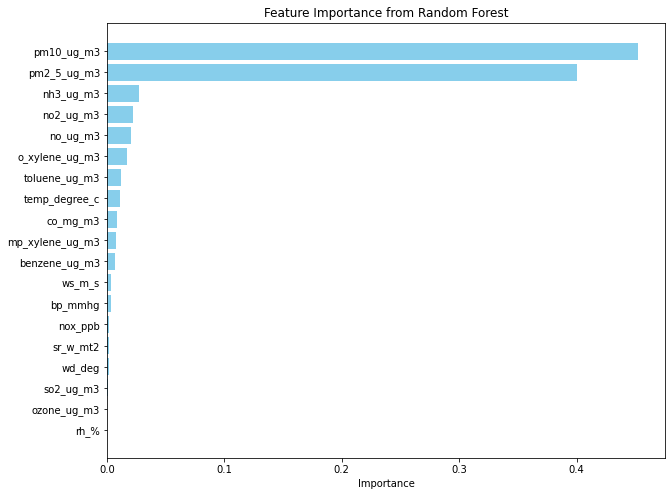

+--------------+---------+--------+----------+---------+-----------+----------+----------+--------------+------------+
|o_xylene_ug_m3|nh3_ug_m3|no_ug_m3|pm10_ug_m3|no2_ug_m3|pm2_5_ug_m3| from_date|   to_date|         state|AQI_Category|
+--------------+---------+--------+----------+---------+-----------+----------+----------+--------------+------------+
|          2.65|      3.8|    3.68|      51.5|    17.15|      23.75|2017-07-03|2017-07-03|Andhra Pradesh|    Moderate|
|          2.65|     3.65|     2.5|     157.5|    20.93|       75.5|2017-07-07|2017-07-07|Andhra Pradesh|   Unhealthy|
|          2.65|      3.2|    1.58|     121.5|     14.0|       67.5|2017-07-08|2017-07-08|Andhra Pradesh|   Unhealthy|
|          2.65|     3.48|     1.5|      56.0|      9.0|       23.5|2017-07-15|2017-07-15|Andhra Pradesh|    Moderate|
|          2.65|     2.38|    1.97|      40.5|    13.12|      33.75|2017-07-17|2017-07-17|Andhra Pradesh|    Moderate|
|          2.65|     4.13|    1.43|     112.0|  

In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

# Initialize Spark session
spark = SparkSession.builder \
    .appName("AQI Feature Importance") \
    .getOrCreate()

# Read DataFrame from Parquet file
parquet_file_path = "file:///home/talentum/myproject/dataSource/output/df_with_aqi_parquet/*.parquet"
df_with_aqi = spark.read.parquet(parquet_file_path)

# Encode the target column 'AQI_Category' if it's categorical
indexer = StringIndexer(inputCol='AQI_Category', outputCol='label')

# Define the features (excluding the target and any irrelevant columns)
feature_columns = ['bp_mmhg', 'benzene_ug_m3', 'mp_xylene_ug_m3', 'o_xylene_ug_m3', 'co_mg_m3',
                   'nh3_ug_m3', 'so2_ug_m3', 'temp_degree_c', 'wd_deg', 'nox_ppb', 
                   'no_ug_m3', 'toluene_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'sr_w_mt2',
                   'ws_m_s', 'no2_ug_m3', 'pm2_5_ug_m3', 'rh_%']

# Assemble features into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a pipeline to apply StringIndexer and VectorAssembler
pipeline = Pipeline(stages=[indexer, assembler])

# Fit and transform the data
df_prepared = pipeline.fit(df_with_aqi).transform(df_with_aqi)

# Initialize the Random Forest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)

# Train the model
rf_model = rf.fit(df_prepared)

# Extract feature importances
importances = rf_model.featureImportances

# Create a list of (feature, importance) tuples
feature_importance_list = [(feature, importance) for feature, importance in zip(feature_columns, importances)]
print("Feature Importances:")
for feature, importance in feature_importance_list:
    print(f"{feature}: {importance:.4f}")


# Convert the feature importance list to a Pandas DataFrame for easier plotting
importance_df = pd.DataFrame(feature_importance_list, columns=['Feature', 'Importance'])

# Sort the DataFrame by importance for better visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()


# Filter based on a threshold (e.g., importance >= 0.0520)
selected_features = [feature for feature, importance in feature_importance_list if importance >0.012446]

# Add additional columns like 'from_date', 'to_date', 'state'
selected_features.extend(['from_date', 'to_date', 'state',"AQI_Category"])

# Create a new DataFrame with the selected features
new_df = df_with_aqi.select(*selected_features)

# Show the new DataFrame with selected features
new_df.show()
print(new_df.count())

# Save the DataFrame as a single Parquet file
output_path = "file:///home/talentum/myproject/dataSource/output/df_for_ML"

# Coalesce the DataFrame to a single partition before writing
df_with_aqi.coalesce(1).write.mode("overwrite").parquet(output_path)
# Stop the Spark session
spark.stop()


In [ ]:
# !pip install scikit-learn
# !pip install plotly
# pdf.unpersist()

# Prediction Model

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Import the machine learning models
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

In [15]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Prediction Model") \
    .getOrCreate()

# # Read DataFrame from Parquet file
parquet_file_path = "file:///home/talentum/myproject/dataSource/output/df_for_ML/*.parquet"
df_with_aqi = spark.read.parquet(parquet_file_path)
# new_df=df_with_aqi


# Get a random sample of rows and limit to 100,000 rows
new_df = df_with_aqi.sample(withReplacement=False, fraction=1.0, seed=42).limit(1000000)

# Print the count of rows in the new DataFrame
print(new_df.count())

1000000


### 1) First, let's prepare the data for modeling.

In [16]:
# StringIndexer for the categorical target column
indexer = StringIndexer(inputCol='AQI_Category', outputCol='label')

# VectorAssembler to combine feature columns into a single vector
feature_cols = [col for col in new_df.columns if col not in ['AQI_Category', 'from_date', 'to_date', 'state']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Split the data into training and testing sets
train_df, test_df = new_df.randomSplit([0.8, 0.2], seed=42)

### 2) Model Building with Hyperparameter Tuning

#### Now, let's define the models with hyperparameter grids and use cross-validation for tuning.

In [ ]:
# Define models
lr = LogisticRegression(maxIter=10)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

# Define hyperparameter grids
lr_param_grid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.1, 0.01])
                 .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                 .build())

dt_param_grid = (ParamGridBuilder()
                 .addGrid(dt.maxDepth, [5, 10, 20])
                 .addGrid(dt.maxBins, [32, 64])
                 .build())

rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [20, 50])
                 .addGrid(rf.maxDepth, [5, 10])
                 .build())

# Define CrossValidator
crossval = CrossValidator(estimator=None,
                          estimatorParamMaps=None,
                          evaluator=MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy'),
                          numFolds=3)

# Set up pipelines and cross-validate each model
def cross_validate_model(model, param_grid, train_df):
    pipeline = Pipeline(stages=[indexer, assembler, model])
    crossval.setEstimator(pipeline)
    crossval.setEstimatorParamMaps(param_grid)
    cv_model = crossval.fit(train_df)
    return cv_model

# Train and tune models
lr_model = cross_validate_model(lr, lr_param_grid, train_df)
dt_model = cross_validate_model(dt, dt_param_grid, train_df)
rf_model = cross_validate_model(rf, rf_param_grid, train_df)  

### 3) Model Evaluation

After tuning the models, let's evaluate their performance on the test dataset.


In [ ]:
# Evaluate models
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
predictions = [lr_model.transform(test_df), 
               dt_model.transform(test_df), 
               rf_model.transform(test_df)]

# Initialize evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
rmse_evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')

accuracies = []
rmses = []

for preds in predictions:
    accuracy = accuracy_evaluator.evaluate(preds)
    # For RMSE, RegressionEvaluator expects continuous numerical predictions,
    # which is not typical for classification, but you can still compute it as:
    rmse = rmse_evaluator.evaluate(preds)
    accuracies.append(accuracy)
    rmses.append(rmse)

# Create a summary DataFrame for comparison
summary_df = spark.createDataFrame(zip(models, accuracies, rmses), schema=['Model', 'Accuracy', 'RMSE'])

# Display the summary
summary_df.show()


In [ ]:
# for 1 lakh rows
# +-------------------+------------------+-------------------+
# |              Model|          Accuracy|               RMSE|
# +-------------------+------------------+-------------------+
# |Logistic Regression|0.7868275515334339| 0.7197214700629562|
# |      Decision Tree|0.9862745098039216|0.18786728732554484|
# |      Random Forest|0.9850678733031675|  0.184219031545903|
# +-------------------+------------------+-------------------+

# for 5 lakh rows
# +-------------------+------------------+------------------+
# |              Model|          Accuracy|              RMSE|
# +-------------------+------------------+------------------+
# |Logistic Regression|0.7566911440150876|1.1789581067226291|
# |      Decision Tree| 0.980036916656635|0.3303404826492617|
# |      Random Forest|0.9631335018658962| 0.452766819705201|
# +-------------------+------------------+------------------+





### 4) Visualization

Finally, we will plot the accuracies and RMSE values for comparison.
 

In [ ]:
# Visualization

# Collect the summary data to plot
summary_pd = summary_df.toPandas()

# Plot accuracy and RMSE
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.barh(summary_pd['Model'], summary_pd['Accuracy'], color='blue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.barh(summary_pd['Model'], summary_pd['RMSE'], color='green')
plt.xlabel('RMSE')
plt.title('Model RMSE')

plt.tight_layout()
plt.show()
spark.stop()

# ARIMA Model

In [ ]:
pdf = new_df
pdf = pdf.orderBy(col("from_date"))
# Convert to Pandas DataFrame for ARIMA modeling
pandas_df = pdf.toPandas()

# Set the date as the index
pandas_df.set_index('from_date', inplace=True)

In [ ]:
from pyspark.ml.feature import VectorAssembler  
import pmdarima as pm
from pmdarima import model_selection

# Split data into train and test
train, test = model_selection.train_test_split(pandas_df, test_size=0.2)

# Fit the ARIMA model
arima_model = pm.auto_arima(train['pm10_ug_m3'], 
                            start_p=1, start_q=1,
                            test='adf',
                            max_p=3, max_q=3, m=1,
                            start_P=0, seasonal=False,
                            d=None, D=0, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

# Summary of the model
print(arima_model.summary())

# Forecast
forecast, conf_int = arima_model.predict(n_periods=len(test), return_conf_int=True)

# Convert results to a DataFrame for visualization or further processing
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['forecast'])

forecast_df